# Loading data

We provide a simple guide in how to load your own data and initialize the adata object for downstream analysis. This tutorial assumes that the files are either in txt or mtx format. After running this pipeline, please see the folder test_data for how exactly each data is stored.

The first step to use CoSpar is to construct an ``anndata`` object that stores all relevant data. The key annotations after initialization are:

* **adata.X**: state count matrix, shape (n_cell, n_gene). **This should not be log-normalized.**

* **adata.var_names**: list of gene names, shape (n_genes,).

* **adata.obs['time_info']**: time annotation (type: `str`) for each cell, shape (n_cell,).

* **adata.obs['state_info']**: state annotation for each cell, shape (n_cell, 1). **[Optional. Can be generated in preprocessing.**
        
* **adata.obsm['X_clone']**: clonal labels for each cell in the form of np.array or sparse matrix, shape (n_cell, n_clone).
    
* **adata.obsm['X_pca']**: PCA matrix, shape (n_cell, n_pcs). **[Optional. Can be generated in preprocessing.**

* **adata.obsm['X_emb']**: two-dimensional embedding, shape (n_cell, 2). **[Optional. Can be generated in preprocessing.**

`cs.pp.initialize_adata_object` assists this initialization.  

In [1]:
import cospar as cs
import pandas as pd
import scipy.io as sio
import numpy as np
import os

In [2]:
cs.logging.print_version()

# Set the messaging level. At a given value, a running function will
# print information at or below its level.
cs.settings.verbosity = 2  # range: 0 (error),1 (warning),2 (info),3 (hint).

# Plot setting. If you want to control a particular plot,
# just change the setting here, and run that plotting function.
cs.settings.set_figure_params(
    format="png", figsize=[4, 3.5], dpi=75, fontsize=14, pointsize=3
)

Running cospar 0.3.0 (python 3.8.16) on 2023-07-14 12:10.


ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI no longer supports 'pip search' (or XML-RPC search). Please use https://pypi.org/search (via a browser) instead. See https://warehouse.pypa.io/api-reference/xml-rpc.html#deprecated-methods for more information.


Each dataset should have its folder to avoid conflicts.  

In [3]:
# set the directory for figures and data. If not existed yet, they will be created automtaically.
cs.settings.data_path = "test_data"  # This name should be exactly 'text_data'
cs.settings.figure_path = "fig_cospar"
cs.hf.set_up_folders()

cs.datasets.raw_data_for_import_exercise()  # download the data

try downloading from url
https://github.com/ShouWenWang-Lab/cospar/files/12036732/test_data.zip
... this may take a while but only happens once


  0%|          | 0.00/2.10M [00:00<?, ?B/s]

## Import method A
Assuming that the X_clone data is stored in mtx format

In [4]:
df_cell_id = pd.read_csv(os.path.join(cs.settings.data_path, "cell_id.txt"))
df_cell_id.head()

,Cell_ID
0,cell_10
1,cell_13
2,cell_18
3,cell_32
4,cell_70


In [5]:
df_gene = pd.read_csv(os.path.join(cs.settings.data_path, "gene_names.txt"))
df_gene.head()

,gene_names
0,0610009L18Rik
1,0610037L13Rik
2,1110012L19Rik
3,1110020A21Rik
4,1110028F11Rik


In [6]:
df_time = pd.read_csv(os.path.join(cs.settings.data_path, "time_info.txt"))
df_time.head()

,time_info
0,6
1,6
2,6
3,6
4,6


In [7]:
RNA_count_matrix = sio.mmread(
    os.path.join(cs.settings.data_path, "gene_expression_count_matrx.mtx")
)
RNA_count_matrix

<781x2481 sparse matrix of type '<class 'numpy.float64'>'
	with 225001 stored elements in COOrdinate format>

In [8]:
X_clone = sio.mmread(os.path.join(cs.settings.data_path, "cell_by_clone_matrx.mtx"))
X_clone

<781x339 sparse matrix of type '<class 'numpy.int64'>'
	with 781 stored elements in COOrdinate format>

In [9]:
df_state = pd.read_csv(os.path.join(cs.settings.data_path, "state_info.txt"))
df_state.head()

,state_info
0,Neutrophil
1,Baso
2,Monocyte
3,Monocyte
4,Baso


In [10]:
df_X_emb = pd.read_csv(os.path.join(cs.settings.data_path, "embedding.txt"))
df_X_emb.head()

,x,y
0,1165.708,-2077.047
1,-980.871,-2055.629
2,2952.953,281.797
3,1314.821,-560.760
4,-1067.502,-1275.488


In [11]:
X_emb = np.array([df_X_emb["x"], df_X_emb["y"]]).T

Now, initialize the adata object

In [12]:
adata_orig = cs.pp.initialize_adata_object(
    X_state=RNA_count_matrix,
    gene_names=df_gene["gene_names"],
    cell_names=df_cell_id["Cell_ID"],
    time_info=df_time["time_info"],
    X_clone=X_clone,
    state_info=df_state["state_info"],
    X_emb=X_emb,
    data_des="my_data",
)

Create new anndata object
Time points with clonal info: ['2' '4' '6']


/Users/shouwen/Documents/packages/cospar/cospar/preprocessing/_preprocessing.py:96: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(ssp.csr_matrix(X_state))


Update the time ordering. A correct time ordering is assumed later.

In [13]:
cs.hf.update_time_ordering(adata_orig, updated_ordering=["2", "4", "6"])

In [14]:
adata_orig

AnnData object with n_obs × n_vars = 781 × 2481
    obs: 'time_info', 'state_info'
    uns: 'data_des', 'time_ordering', 'clonal_time_points'
    obsm: 'X_clone', 'X_emb'

Alternatively, you can initialize the object by building on an existing adata object. This will keep existing annotations from the old adata. You can make modifications by specifying additional entries.

In [15]:
adata_orig_new = cs.pp.initialize_adata_object(adata=adata_orig, X_clone=X_clone)

Time points with clonal info: ['2' '4' '6']


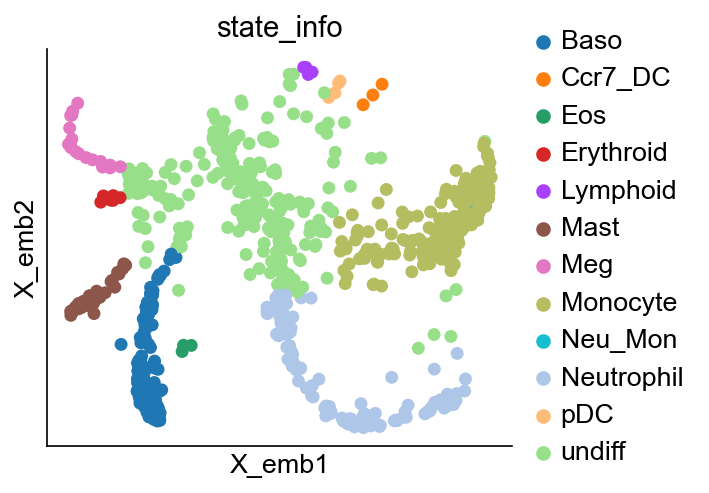

In [16]:
cs.pl.embedding(adata_orig, color="state_info")

## Import method B
Assuming that the X_clone data is stored in a (cell_id, barcode_id) format

First, initialize the adata without concerning the clonal data

In [17]:
df_cell_id = pd.read_csv(os.path.join(cs.settings.data_path, "cell_id.txt"))
df_gene = pd.read_csv(os.path.join(cs.settings.data_path, "gene_names.txt"))
df_time = pd.read_csv(os.path.join(cs.settings.data_path, "time_info.txt"))
RNA_count_matrix = sio.mmread(
    os.path.join(cs.settings.data_path, "gene_expression_count_matrx.mtx")
)
df_state = pd.read_csv(os.path.join(cs.settings.data_path, "state_info.txt"))
df_X_emb = pd.read_csv(os.path.join(cs.settings.data_path, "embedding.txt"))
X_emb = np.array([df_X_emb["x"], df_X_emb["y"]]).T

In [18]:
adata_orig = cs.pp.initialize_adata_object(
    X_state=RNA_count_matrix,
    gene_names=df_gene["gene_names"],
    cell_names=df_cell_id["Cell_ID"],
    time_info=df_time["time_info"],
    state_info=df_state["state_info"],
    X_emb=X_emb,
    data_des="my_data",
)

Create new anndata object
Time points with clonal info: []


/Users/shouwen/Documents/packages/cospar/cospar/preprocessing/_preprocessing.py:96: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(ssp.csr_matrix(X_state))


Now, load the clonal data. Here, we start with a table of (cell_id, clone_id) pair. The cell_id does not need to be ranked. It should match the cell_id in the ``adata_orig.obs_names``

In [19]:
df_X_clone = pd.read_csv(
    os.path.join(cs.settings.data_path, "clonal_data_in_table_format.txt")
)
df_X_clone

,Cell_ID,Clone_ID
0,cell_0,clone_275
1,cell_1,clone_329
2,cell_2,clone_56
3,cell_3,clone_236
4,cell_4,clone_213
...,...,...
776,cell_776,clone_196
777,cell_777,clone_239
778,cell_778,clone_259
779,cell_779,clone_217


In [20]:
adata_orig.obs_names

Index(['cell_10', 'cell_13', 'cell_18', 'cell_32', 'cell_70', 'cell_80',
       'cell_90', 'cell_97', 'cell_108', 'cell_117',
       ...
       'cell_7389', 'cell_7392', 'cell_7402', 'cell_7407', 'cell_7409',
       'cell_7417', 'cell_7423', 'cell_7435', 'cell_7436', 'cell_7437'],
      dtype='object', length=781)

In [21]:
cs.pp.get_X_clone(adata_orig, df_X_clone["Cell_ID"], df_X_clone["Clone_ID"])

100%|███████████████████████████████████████| 87/87 [00:00<00:00, 412321.41it/s]

reorder clones


In [22]:
adata_orig

AnnData object with n_obs × n_vars = 781 × 2481
    obs: 'time_info', 'state_info'
    uns: 'data_des', 'time_ordering', 'clonal_time_points', 'clone_id'
    obsm: 'X_clone', 'X_emb'

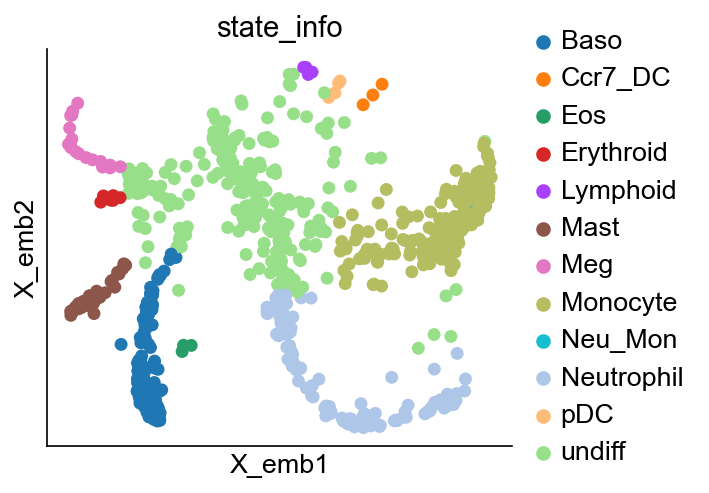

In [23]:
cs.pl.embedding(adata_orig, color="state_info")